In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import datetime as dt

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import plotly.express as px
import folium 
import folium.plugins
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import warnings
warnings.filterwarnings("ignore")

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()

Loading BokehJS ...

In [2]:
# data loading and cleaning
dt1 = pd.read_csv('data/trip_data/trip_data_3.csv', nrows=100000)
dt1.drop(columns=' store_and_fwd_flag', inplace=True)
# dt2 = pd.read_csv('data/trip_data/trip_data_2.csv')

df1 = pd.read_csv('data/trip_fare/trip_fare_3.csv', nrows=100000)
# df2 = pd.read_csv('data/trip_fare/trip_fare_2.csv')
df = pd.merge(dt1, df1, how='left', on=['medallion', ' hack_license', ' vendor_id', ' pickup_datetime'])
for i in df.columns:
    df.rename(columns={i : i.strip(' ')}, inplace=True)
df['trip_time'] = df['trip_time_in_secs']/60
coord = ['pickup_longitude','pickup_latitude', 
         'dropoff_longitude', 'dropoff_latitude']

for i in coord :
    df[i] = df[i].replace(0,np.nan)
df.dropna(inplace=True)
# drop observations less than 0 and  greater than 99.9% percentile value.
df = df[(df["fare_amount"] > 0) & (
    df["fare_amount"] < df["fare_amount"].quantile(.999))]

df = df[(df["trip_distance"] > 0) & (
    df["trip_distance"] < df["trip_distance"].quantile(.9999))]

df = df[(df["trip_time_in_secs"] > 0) & (
    df["trip_time_in_secs"] < df["trip_time_in_secs"].quantile(.9999))]

for i in coord:
    df = df[(df[i] > df[i].quantile(.001)) &
            (df[i] < df[i].quantile(.999))]
    
    
pickupTime = pd.to_datetime(df['pickup_datetime'])

df['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
df['dst hourOfDay'] = df['src hourOfDay'] + df['trip_time'] / 60.0

df['dayOfWeek']     = pickupTime.dt.weekday
df['hourOfWeek']    = df['dayOfWeek']*24.0 + df['src hourOfDay']

allLat  = np.array(list(df['pickup_latitude'])  + list(df['dropoff_latitude']))
allLong = np.array(list(df['pickup_longitude']) + list(df['dropoff_longitude']))

medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

df['src lat']   = latMultiplier  * (df['pickup_latitude']   - medianLat)
df['src long']  = longMultiplier * (df['pickup_longitude']  - medianLong)
df['dst lat']   = latMultiplier  * (df['dropoff_latitude']  - medianLat)
df['dst long']  = longMultiplier * (df['dropoff_longitude'] - medianLong)
df = df.reset_index(drop=True)

allLat  = np.array(list(df['src lat'])  + list(df['dst lat']))
allLong = np.array(list(df['src long']) + list(df['dst long']))


In [4]:
df.groupby(by= '').plot(kind='hist')

TypeError: no numeric data to plot

# Maps and density plot

In [84]:
#plot datapoints by location coordinates
def plot_data_points(longitude,latitude,data_frame,focus_point):
    
    #plot dimensions
#     x_range, y_range = ((-74.14,-73.73), (40.6,40.9))
#     plot_width  = int(750)
#     plot_height = int(plot_width//1.2)
    export  = partial(export_image, export_path="export", background="black")
    fig = figure(background_fill_color = "black")    
    #plot data points
    cvs = ds.Canvas()
    agg = cvs.points(data_frame,longitude,latitude,
                      ds.count(focus_point))
    img = tf.shade(agg, cmap= Hot, how='eq_hist')
    image_xpt  =  tf.dynspread(img, threshold=0.5, max_px=4)
    
    return export(image_xpt,"Data")

In [85]:
a = plot_data_points('src long', 'src lat',df,"passenger_count")

In [86]:
type(a)

datashader.transfer_functions.Image

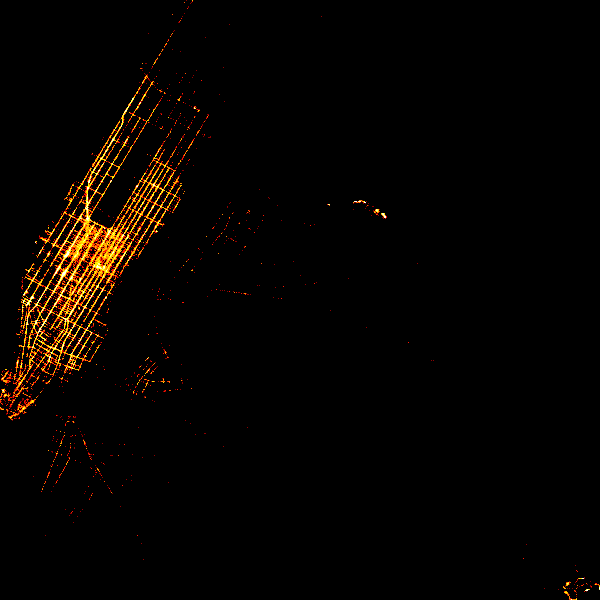

In [87]:
a

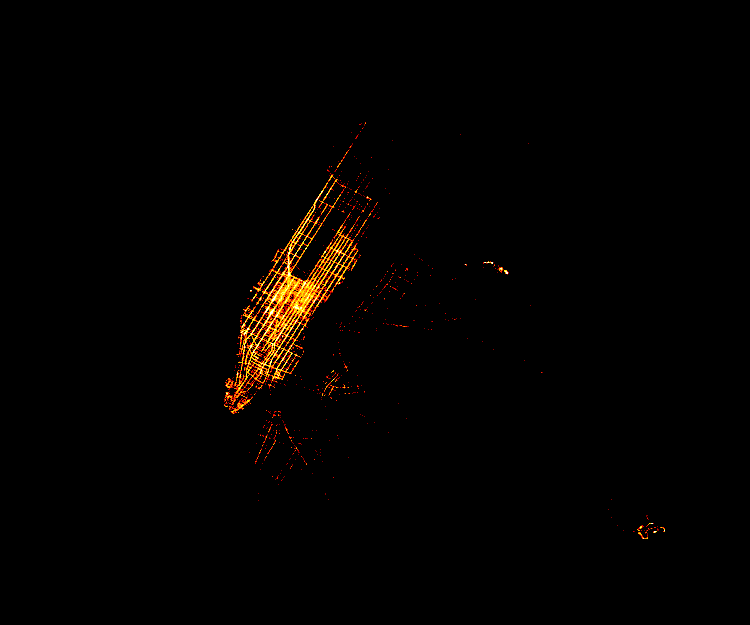

In [17]:
plot_data_points('pickup_longitude', 'pickup_latitude',df,"fare_amount")

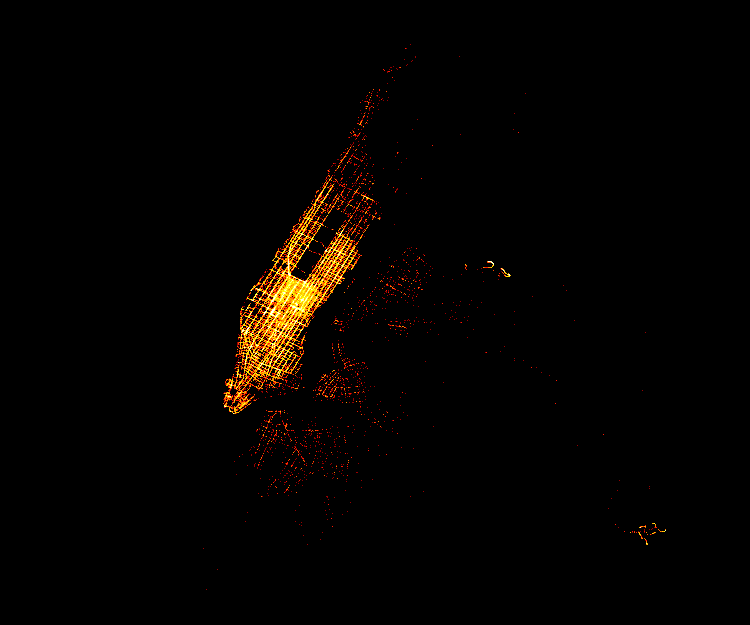

In [28]:
plot_data_points('dropoff_longitude', 'dropoff_latitude',df,"fare_amount")

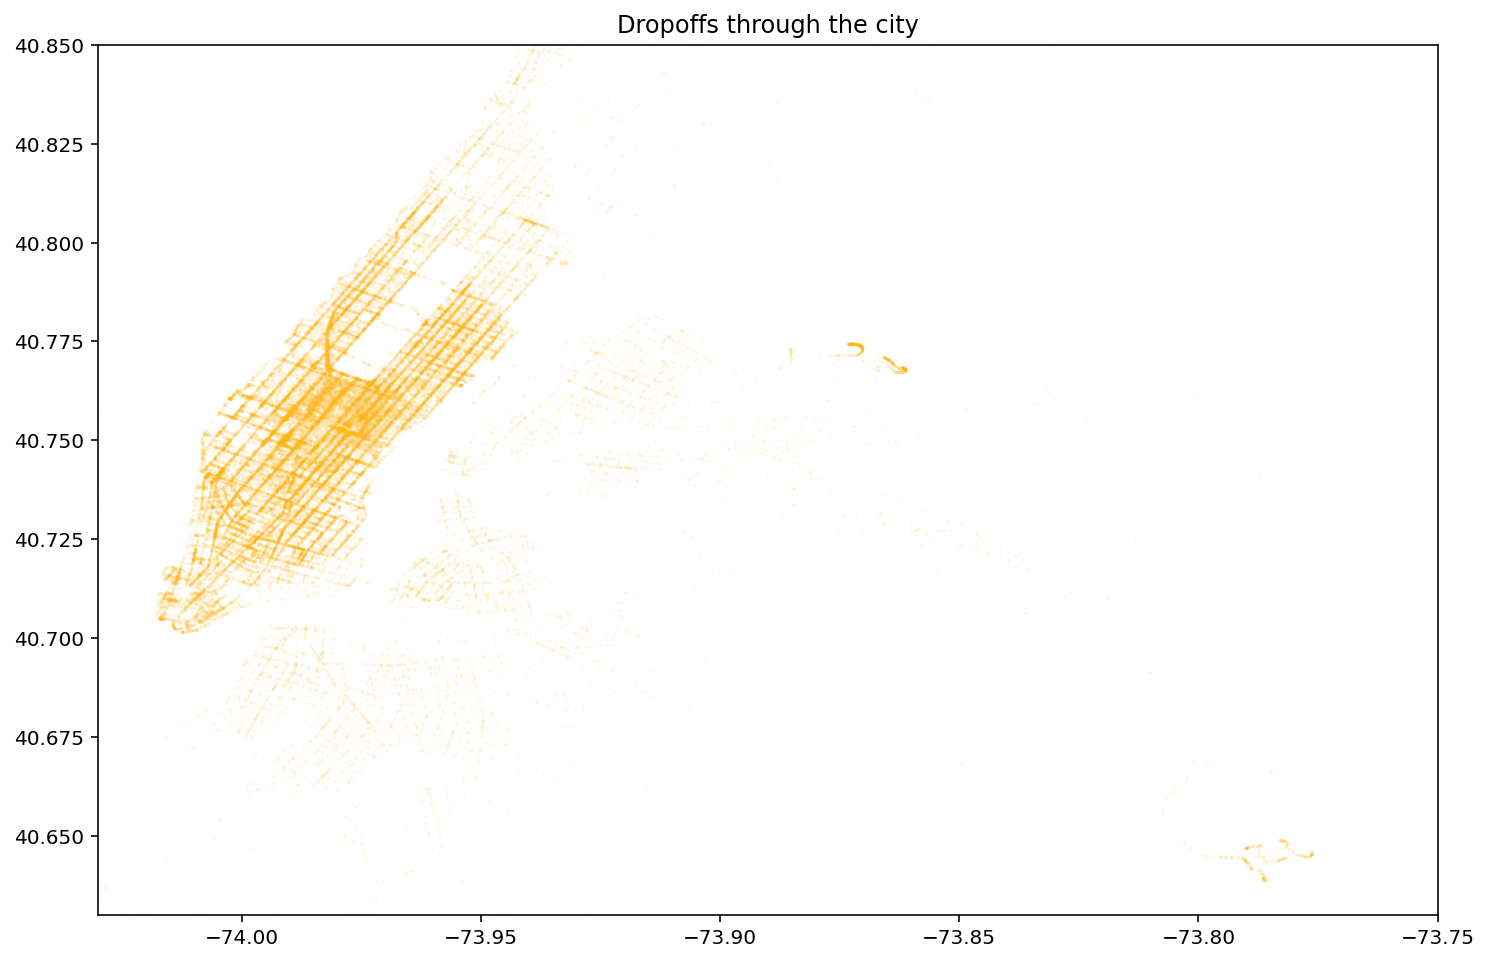

In [206]:
dropoff_longitude = df['dropoff_longitude'].to_numpy()
dropoff_latitude = df['dropoff_latitude'].to_numpy()

plt.figure(figsize=(12,8))
plt.scatter(dropoff_longitude, dropoff_latitude,
                color="#fdb813", 
                s=.02, alpha=.2)
plt.title("Dropoffs through the city")
# Borders of the city
plt.xlim(-74.03, -73.75)
plt.ylim(40.63, 40.85)
plt.show()

In [30]:
df.dtypes

medallion             object
hack_license          object
vendor_id             object
rate_code              int64
pickup_datetime       object
dropoff_datetime      object
passenger_count        int64
trip_time_in_secs      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
trip_time            float64
src hourOfDay        float64
dst hourOfDay        float64
dayOfWeek              int64
hourOfWeek           float64
src lat              float64
src long             float64
dst lat              float64
dst long             float64
dtype: object

In [53]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import decomposition
from scipy import stats

# CLUSTERING

In [44]:
tripAttributes.shape

(97307, 5)

In [138]:
tripAttributes = np.array(df[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
# tripAttributes = stats.zscore(tripAttributes, axis=0)



In [139]:
numClusters = 80
TripKmeansModel = MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds1 = TripKmeansModel.fit_predict(tripAttributes)

In [131]:
clusterInds = clusterInds1

In [132]:
clusterInds

array([ 3, 63, 39, ...,  0, 39, 73], dtype=int32)

In [111]:
# show the log density of pickup and dropoff locations
imageSize = (1000, 1000)
longRange = [min(allLong), max(allLong)]
latRange = [min(allLat), max(allLat)]

allLatInds = imageSize[0] - (imageSize[0] * (allLat -
                             latRange[0]) / (latRange[1] - latRange[0])).astype(int)
allLongInds = (imageSize[1] * (allLong - longRange[0]) /
               (longRange[1] - longRange[0])).astype(int)

In [182]:
clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

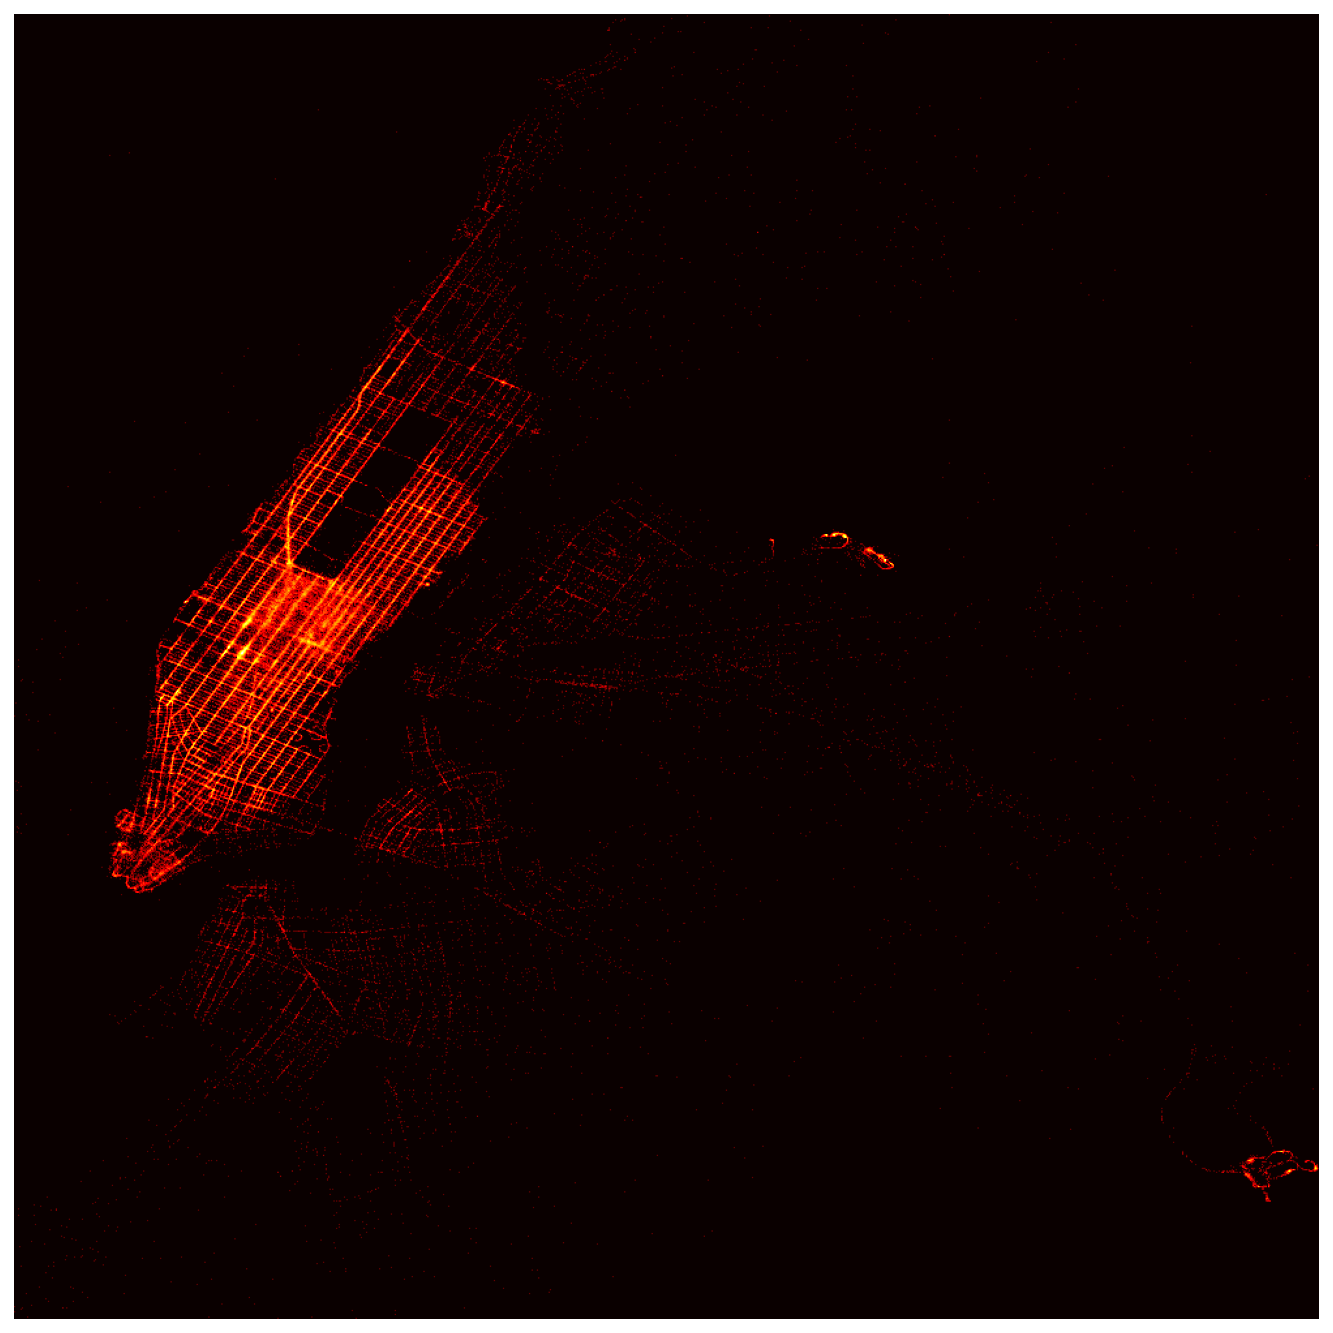

In [122]:
locationDensityImage = np.zeros((1001,1001))
for i, j in zip(allLatInds, allLongInds):
    locationDensityImage[i, j] += 1

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
ax.imshow(np.log(locationDensityImage+1), cmap='hot')
ax.set_axis_off()

In [141]:
TripKmeansModel.cluster_centers_

array([[ 40.73437378, -74.00057165,  40.72573659, -73.98733427],
       [ 40.76181672, -73.96694627,  40.75701259, -73.97733499],
       [ 40.64700377, -73.78607371,  40.75517972, -73.97982737],
       [ 40.75757339, -73.98114166,  40.77140753, -73.86671757],
       [ 40.81146212, -73.94760727,  40.81357346, -73.94518104],
       [ 40.77022966, -73.86945041,  40.76679135, -73.9672576 ],
       [ 40.75528862, -73.97886593,  40.64607968, -73.78677165],
       [ 40.75913876, -73.97210862,  40.73744741, -74.001045  ],
       [ 40.76327377, -73.98189001,  40.80445645, -73.95694589],
       [ 40.7465971 , -73.99671877,  40.76230098, -73.98462662],
       [ 40.73162357, -73.99369491,  40.67973926, -73.97872029],
       [ 40.76446034, -73.96449145,  40.77592382, -73.95511797],
       [ 40.80528972, -73.96118909,  40.7660817 , -73.97983029],
       [ 40.72537252, -73.99977138,  40.7364829 , -74.00105994],
       [ 40.64554763, -73.78381529,  40.66497841, -73.95171795],
       [ 40.73483824, -73

In [175]:
tripAttributes = np.array(df[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
# tripAttributes = stats.zscore(tripAttributes, axis=0)

numClusters = 100
TripKmeansModel = MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds1 = TripKmeansModel.fit_predict(tripAttributes)

In [176]:
TripKmeansModel.cluster_centers_[:, :2][0][0]

40.7895250320233

In [177]:
lat_center = 40.78
lon_center = -73.62

map_nyc = folium.Map(location=[lat_center,lon_center],
                    tiles="Cartodb dark_matter",max_zoom=15,zoom_start=10)


for i in range(0,80) : 
    
    p1 = (TripKmeansModel.cluster_centers_[:, :2][i][0], TripKmeansModel.cluster_centers_[:, :2][i][1])
    
    p2 = (TripKmeansModel.cluster_centers_[:, 2:4][i][0], TripKmeansModel.cluster_centers_[:, 2:4][i][1])
    
    folium.Marker(location = p1,
                  icon=folium.Icon(color='green',
                                   icon = "home"),
                  popup = "Pick up = " + str(p1),
                 ).add_to(map_nyc)
    
    folium.Marker(location = p2,
                 icon=folium.Icon(color='blue',
                                  icon = "home", ),
                  popup = "Drop off = " + str(p2),
                 ).add_to(map_nyc)
    
    folium.PolyLine(locations = [p1,p2] ,
                    color = "red",opacity = .6,
                   ).add_to(map_nyc)
    
    folium.Circle(
        location=p1,
        color= "green", radius = 200,
        fill=True,
        opacity=1).add_to(map_nyc)
    
    folium.Circle(
        location=p2,
        color= "blue", radius = 300,
        fill=True,
        opacity=1).add_to(map_nyc)
    
   
map_nyc

In [183]:
clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

Text(58, 1.75, 'Silent Nights')

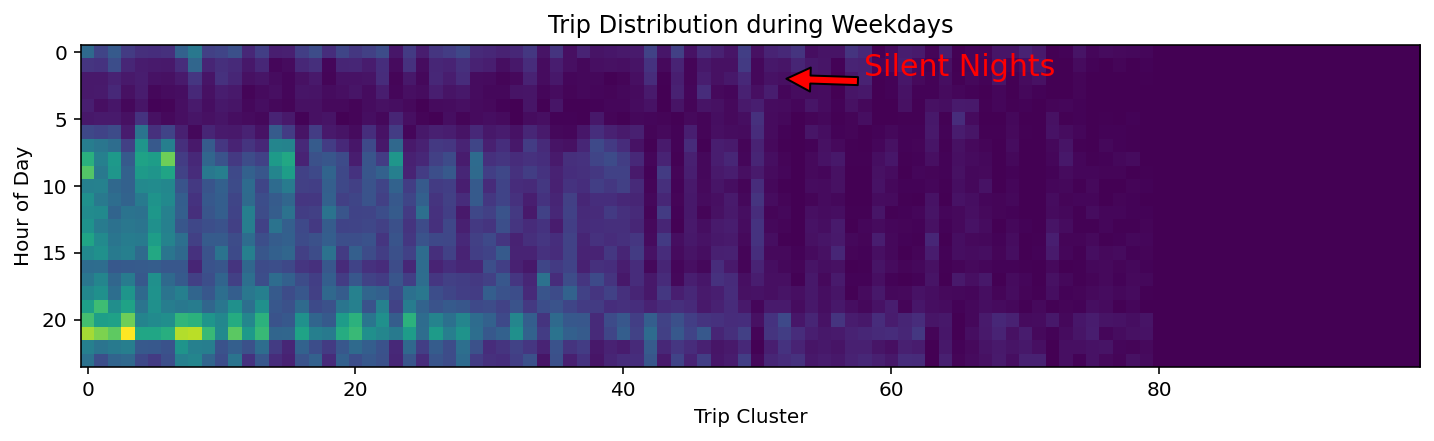

In [191]:
# calculate the trip distribution for different hours of the weekday
hoursOfDay = np.sort(df['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekday = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (df['src hourOfDay'].astype(int) == hour) & (df['dayOfWeek'] <= 4)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekday[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekdays', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekday);
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Silent Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))

Text(58, 9.75, 'Late Mornings')

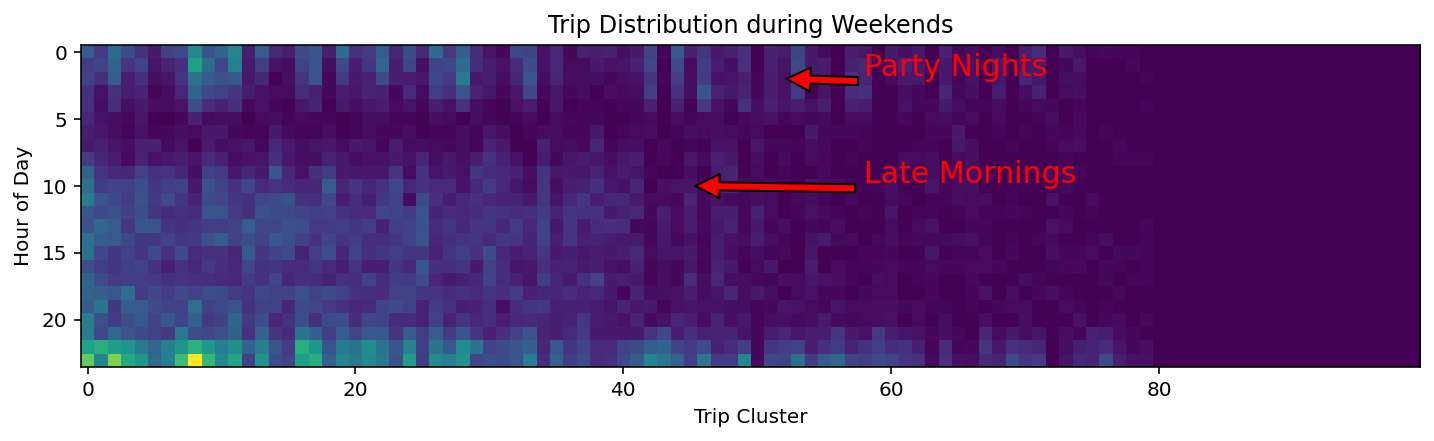

In [200]:
# calculate the trip distribution for different hours of the weekend
hoursOfDay = np.sort(df['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekend = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (df['src hourOfDay'].astype(int) == hour) & (df['dayOfWeek'] >= 5)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekend[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.set_title('Trip Distribution during Weekends', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekend)
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Party Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Late Mornings', color='r', fontsize=15, xy=(45, 10), xytext=(58, 9.75),
            arrowprops=dict(facecolor='red', shrink=0.03))
